In [15]:
import numpy as np
import phate, scprep
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import magic
import gspa

2024-06-24 12:17:58.924907: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 12:17:58.926883: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 12:17:58.963830: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 12:17:58.964258: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 12:17:59.887992: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
trajectory_data = np.load('../data/splatter_simulated_data.npz')
data_libnorm_sqrt = trajectory_data['data']
pseudotime = trajectory_data['pseudotime']
data_libnorm_sqrt= data_libnorm_sqrt[np.argsort(pseudotime)]
pseudotime = np.array(list(range(10000))) / 10000

print ('Compute PHATE...')
phate_op = phate.PHATE(random_state=0, use_pygsp=True, verbose=0, n_jobs=1)
data_phate = phate_op.fit_transform(data_libnorm_sqrt)

Compute PHATE...


In [3]:
signal = StandardScaler().fit_transform(data_phate[:, 0].reshape(-1,1)).flatten()

<Axes: >

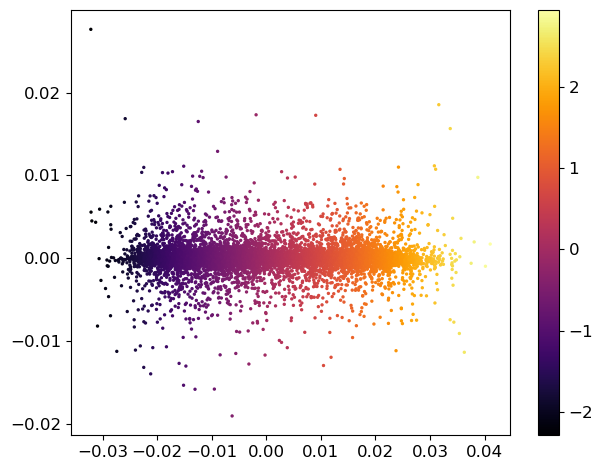

In [4]:
scprep.plot.scatter2d(data_phate, c=signal, filename='figures/designed_signal.png', dpi=200)

In [5]:
sinusoidal = np.sin(4*signal).flatten()

<Axes: >

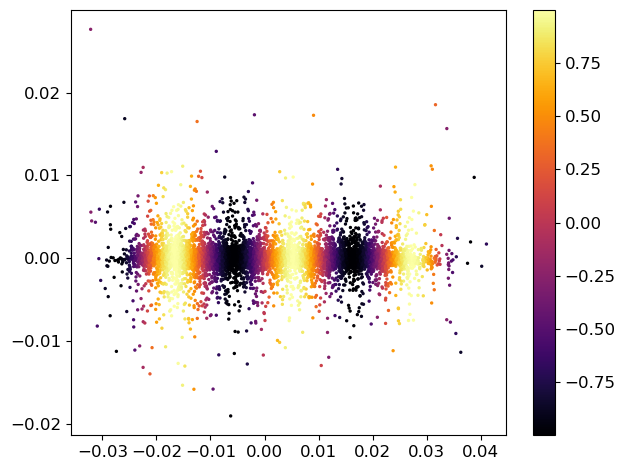

In [6]:
scprep.plot.scatter2d(data_phate, c=sinusoidal, filename='figures/designed_sinusoidal.png', dpi=200)

<Axes: >

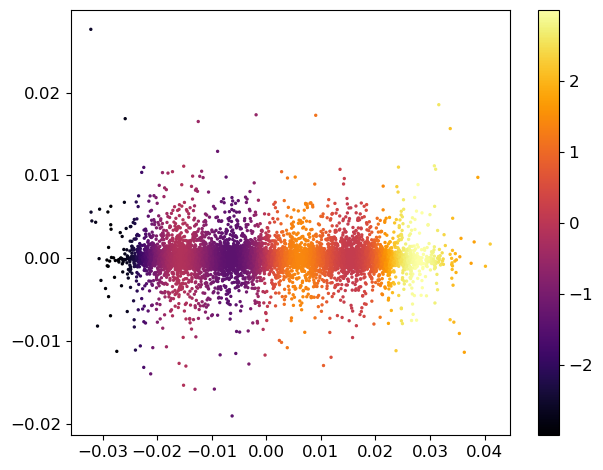

In [7]:
scprep.plot.scatter2d(data_phate, c=signal + sinusoidal)

In [8]:
np.random.seed(0)
noise = np.random.uniform(-1,1, size=signal.shape[0])

<Axes: >

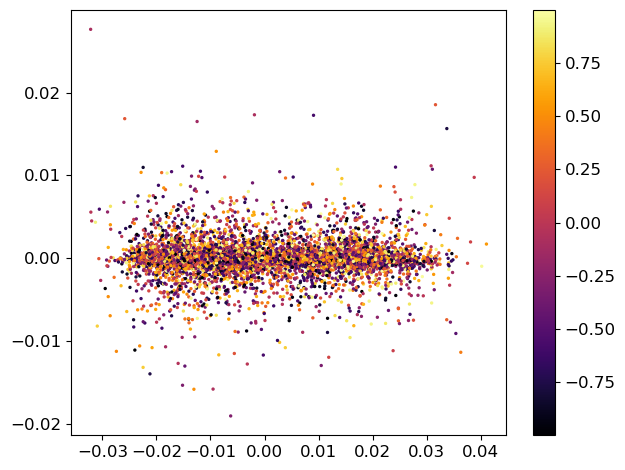

In [9]:
scprep.plot.scatter2d(data_phate, c=noise, filename='figures/designed_noise.png', dpi=200)

<Axes: >

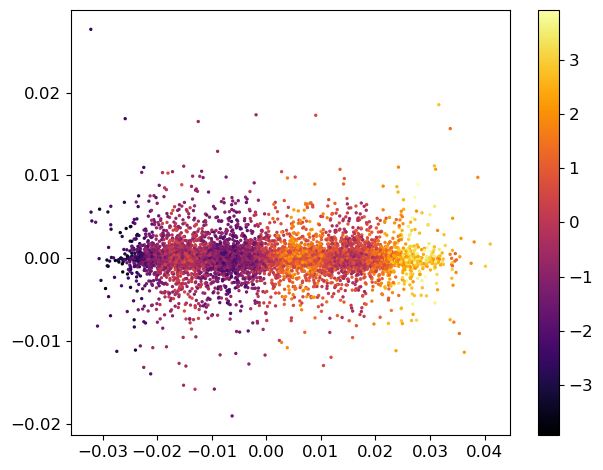

In [10]:
scprep.plot.scatter2d(data_phate, c=signal + sinusoidal + noise, filename='figures/designed_final_signal.png', dpi=200)

In [12]:
magic_op = magic.MAGIC(t=3)
magic_op.graph = phate_op.graph
data_magic = magic_op.transform((signal + sinusoidal + noise).reshape(-1,1))

Calculating imputation...


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


<Axes: >

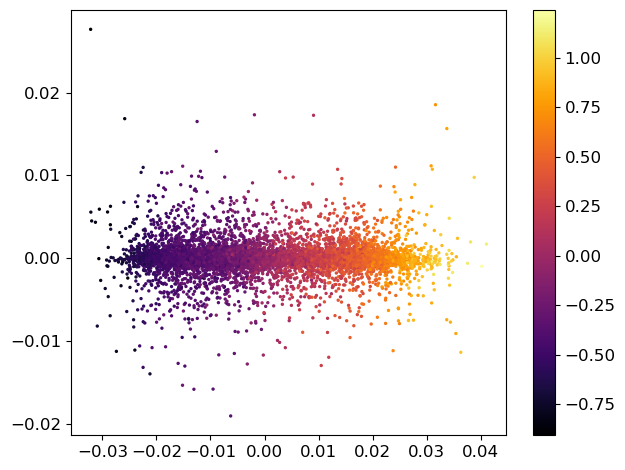

In [13]:
scprep.plot.scatter2d(data_phate, c=data_magic, filename='figures/magic_on_signal.png', dpi=200)

In [17]:
gspa_op = gspa.GSPA(graph=phate_op.graph, qr_decompose=False, wavelet_J=5)
gspa_op.build_diffusion_operator()
gspa_op.build_wavelet_dictionary()

100%|██████████| 3/3 [00:09<00:00,  3.02s/it]


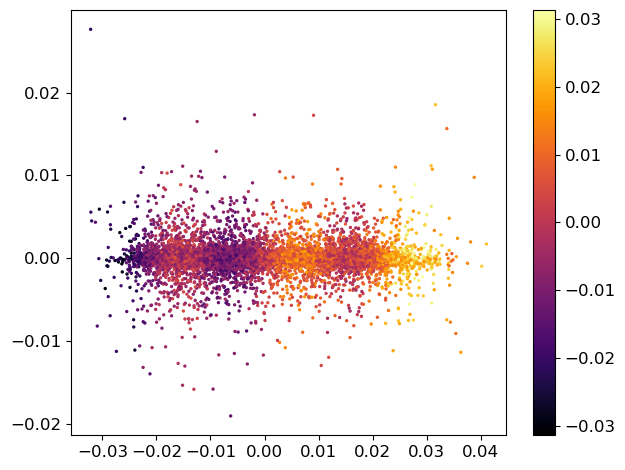

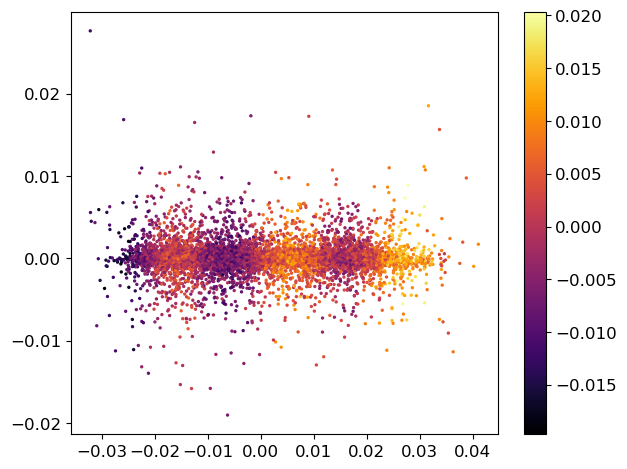

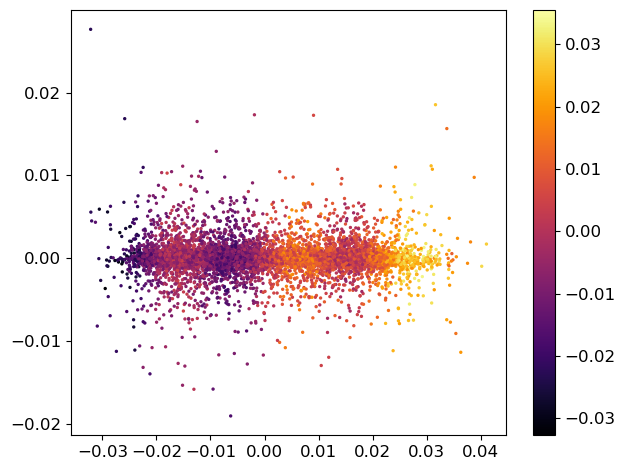

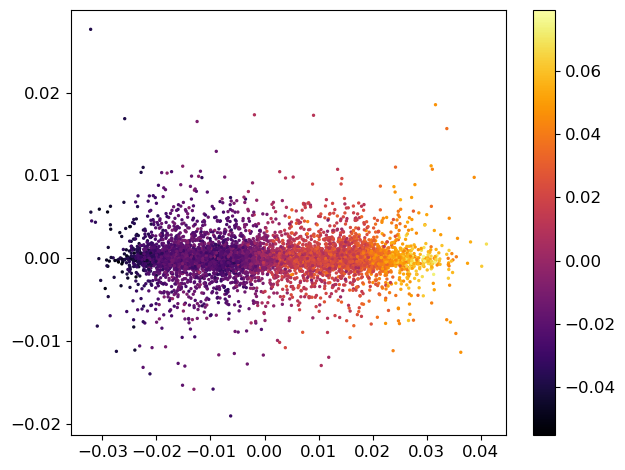

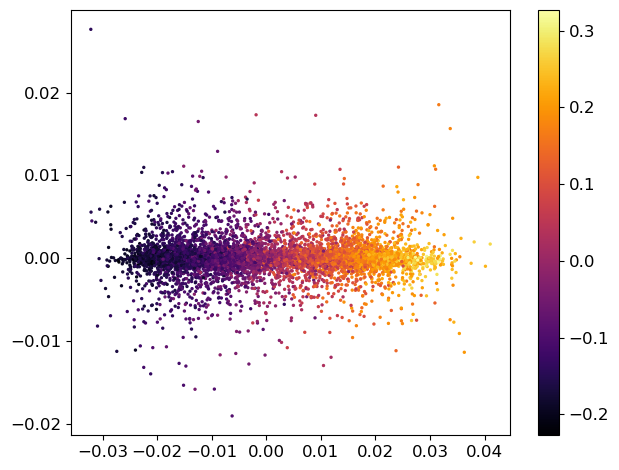

In [22]:
for i in range(5):
    projected_signal = gspa.embedding.project((signal + sinusoidal + noise).reshape(1,-1),
                                              gspa_op.wavelet_dictionary[:, i*10000:(i+1)*10000])
    scprep.plot.scatter2d(data_phate, c=projected_signal, filename=f'figures/projected_on_wavelet_{i+1}_signal.png', dpi=200)